In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import gc
import treecorr
import pyhalofit
import numpy as np
from wl.ximod import *
from wl import pltutil
import matplotlib.pylab as plt
import astropy.io.fits as pyfits

Dir1=  'mockana_ztrue1'
assert os.path.isdir(Dir1)

# linear power spectrum

In [2]:
# linear power
linear_power = camb_class()
nz=70
mnu = 0.0
cparam = np.array([[0.02254,0.11417,0.721,3.083548,0.97,-1.]])
linear_power.set_cosmology(cparam, mnu=mnu, omk=0.0)
zl = np.concatenate([np.logspace(-7,-1.1, nz), np.linspace(1e-1, 4.0, nz)])
linear_power.init_pklin_array(zl)

Note: redshifts have been re-sorted (earliest first)


170

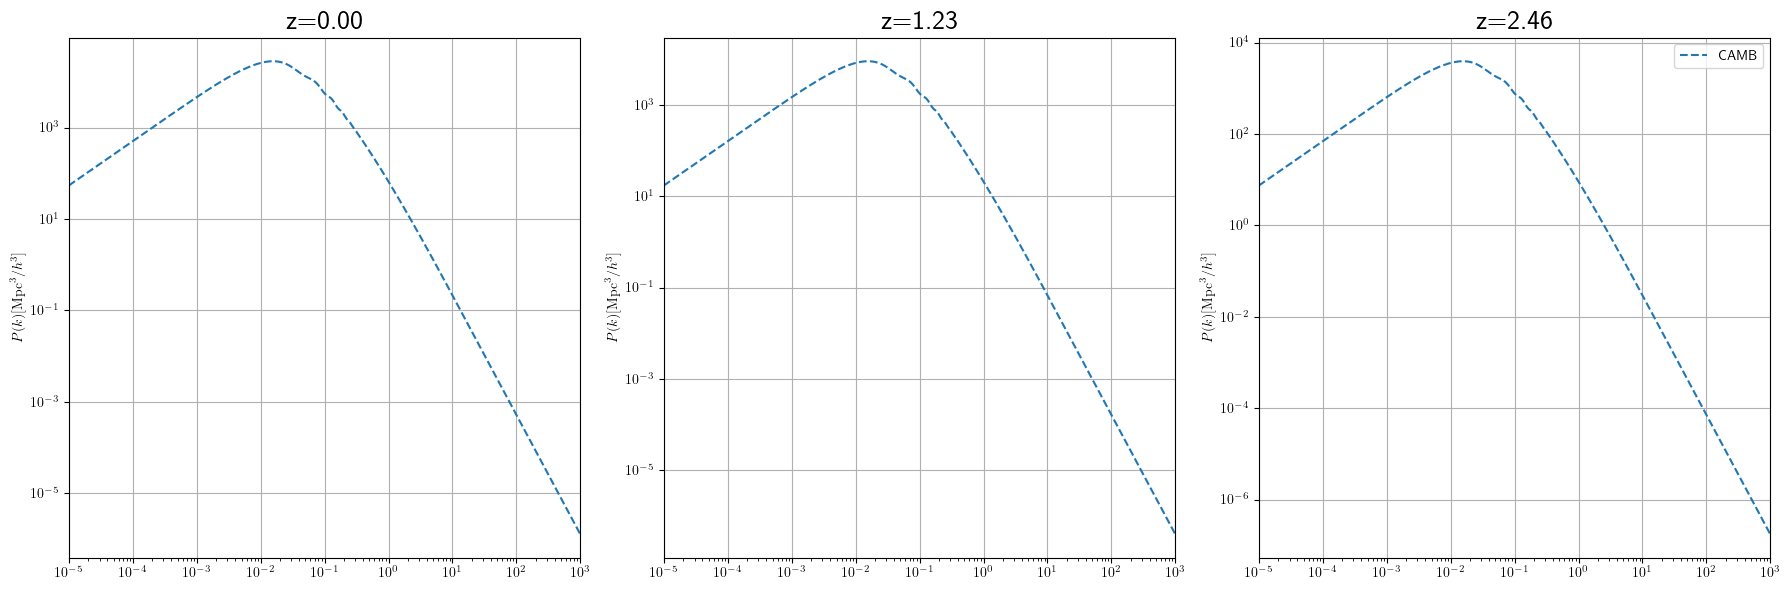

In [3]:
# COSMOSIS
z_lin=np.loadtxt(os.path.join(Dir1,'matter_power_lin/z.txt'))
k_lin=np.loadtxt(os.path.join(Dir1,'matter_power_lin/k_h.txt'))

plt.close()
fig,subfigs=pltutil.make_figure_axes(ny=1,nx=3)
for ix,ax in enumerate(subfigs):
    iz=70*ix
    pk_lin2=linear_power.get_pklin_array_from_z(k=k_lin,z=z_lin[iz])
    ax.plot(k_lin,pk_lin2,'--',label='CAMB')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(r'z=%.2f' %z_lin[iz],fontsize=20)
    ax.set_xlim(1e-5,1e3)
    ax.set_ylabel(r'$P(k)[\mathrm{Mpc}^3/h^3]$')
    ax.grid()
ax.legend()
plt.tight_layout()
gc.collect()

# halofit power spectrum

In [4]:
halofit = pyhalofit.halofit()
halofit.set_cosmology(convert_decosmo2halofitcosmo(cparam, mnu=mnu))
cosmo = halofit.cosmo

150

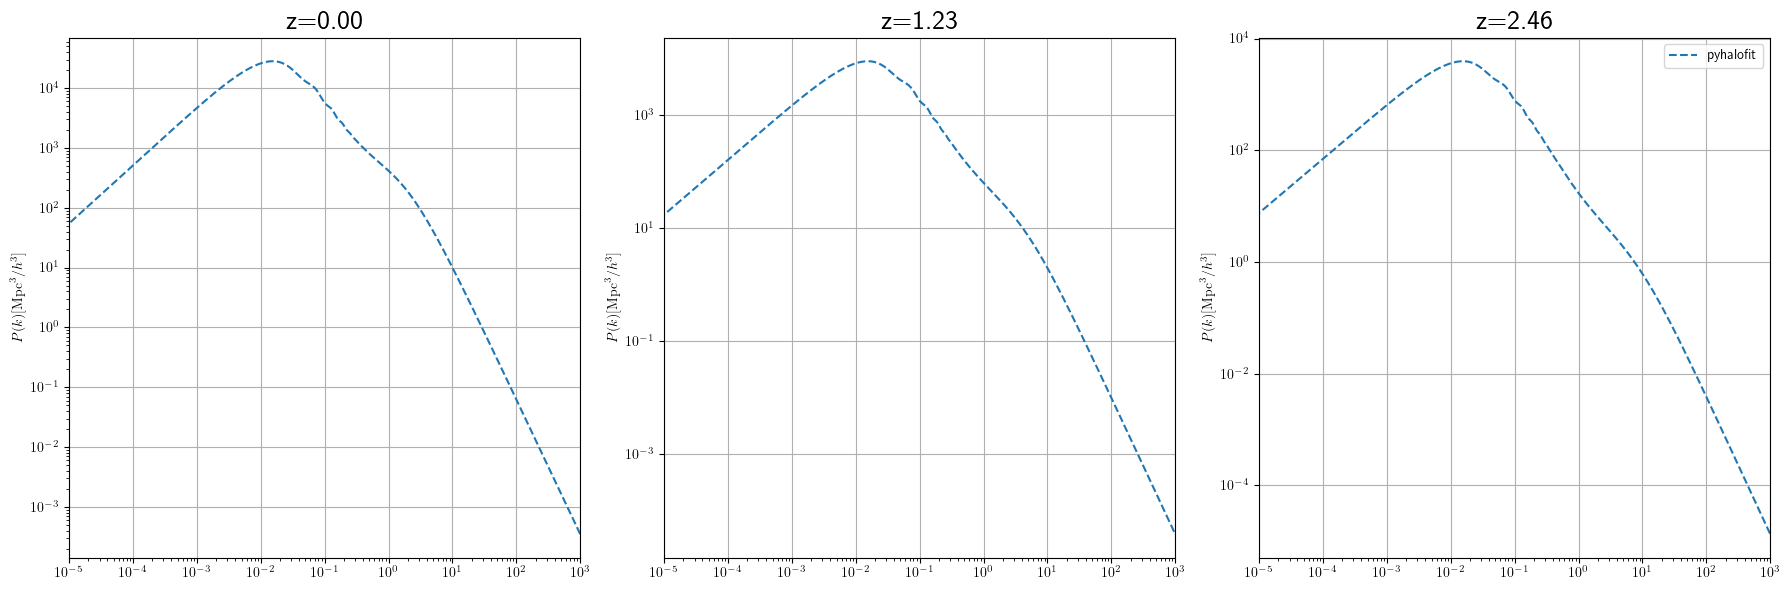

In [5]:
# COSMOSIS
z_nl=np.loadtxt(os.path.join(Dir1,'matter_power_nl/z.txt'))
k_nl=np.loadtxt(os.path.join(Dir1,'matter_power_nl/k_h.txt'))

plt.close()
fig,axes=pltutil.make_figure_axes(ny=1,nx=3)
for ix,ax in enumerate(axes):
    iz=70*ix
    pk_lin2=linear_power.get_pklin_array_from_z(k=k_nl,z=z_lin[iz])
    halofit.set_pklin(k_nl,pk_lin2,z_nl[iz])
    pk_nl2 = halofit.get_pkhalo()
    ax.plot(k_nl,pk_nl2,'--',label='pyhalofit')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r'$P(k)[\mathrm{Mpc}^3/h^3]$')
    ax.set_title(r'z=%.2f' %z_lin[iz],fontsize=20)
    ax.grid()
    ax.set_xlim(1e-5,1e3)
ax.legend()
plt.tight_layout()
gc.collect()

# lensing kernel

Text(0, 0.5, '$n(z)$')

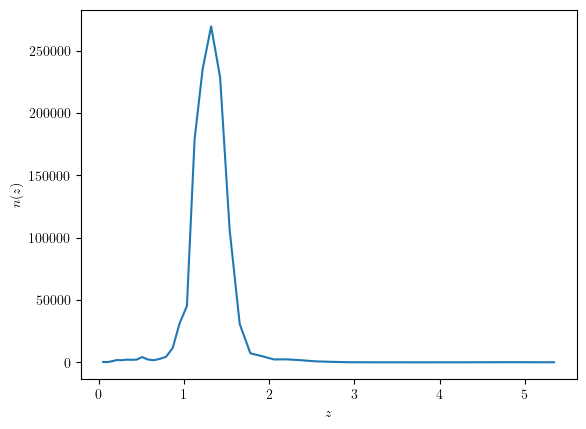

In [6]:
zdata=pyfits.getdata('../2_meas_nz_2pcf/nz_ture_ave.fits')
zmid=   np.array([0.0506,  0.1023,  0.1553,  0.2097, 0.2657,    0.3233,
    0.3827,  0.4442,  0.5078,  0.5739, 0.6425,  0.714,  0.7885, 0.8664,
    0.9479,  1.0334,  1.1233,  1.2179, 1.3176,  1.423 , 1.5345, 1.6528,
    1.7784,  1.9121,  2.0548,  2.2072, 2.3704,  2.5455, 2.7338, 2.9367,
    3.1559,  3.3932,  3.6507,  3.9309, 4.2367,  4.5712, 4.9382,
    5.3423],dtype=float)

# let's test for the second redshift bin
pzs=zdata[-1]
plt.plot(zmid,pzs)
plt.xlabel(r'$z$')
plt.ylabel(r'$n(z)$')

Text(0, 0.5, 'normalized $w(z)$')

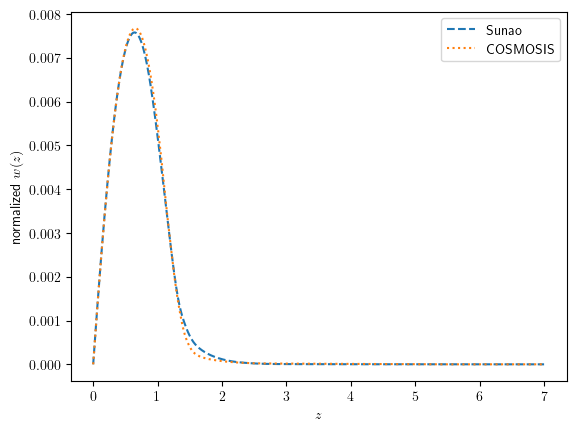

In [7]:
zq=np.loadtxt(os.path.join(Dir1,'kernel_w_sample/z.txt'))
w=np.loadtxt(os.path.join(Dir1,'kernel_w_sample/bin_3.txt'))
q_over_chi_func = efficiency_q_over_chi(zmid, pzs, cosmo)
chis = cosmo.comoving_distance(zq).value
w_c=q_over_chi_func(chis)*chis
plt.plot(zq,w/np.sum(w),'--',label='Sunao')
plt.plot(zq,w_c/np.sum(w_c),':',label='COSMOSIS') 
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'normalized $w(z)$')
# I only compare the shape of lensing kernel, so normalize to 1
# consistent

# shear cl

In [8]:
l=np.loadtxt(os.path.join(Dir1,'shear_cl/ell.txt'))
cl = angular_power_spectrum(l, cosmo, linear_power,
     q_over_chi_func,q_over_chi_func, halofit)

Note: redshifts have been re-sorted (earliest first)


95

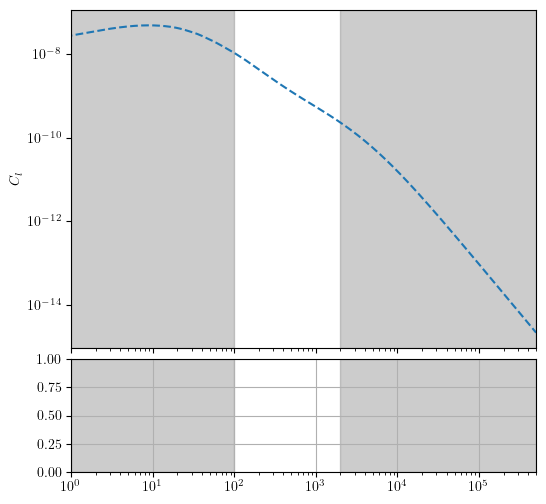

In [9]:
fig=plt.figure(figsize=(6,6))
axes=fig.subplots(2,1,gridspec_kw={'height_ratios':[3, 1],'hspace':0.05},sharex=True)
ax1=axes[0]
ax1.plot(l,cl,'--',label='Model')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1,5e5)
ax1.set_ylabel(r'$C_l$')
ax1.axvspan(2e3, 5e5, alpha=0.4,color='gray')
ax1.axvspan(1, 100, alpha=0.4,color='gray')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2=axes[1]
ax2.axvspan(2e3, 5e5, alpha=0.4,color='gray')
ax2.axvspan(1, 100, alpha=0.4,color='gray')
ax2.grid()
# in COSMOSIS the default limit is from 0.1 to 5e5
gc.collect()
# average bias should be less than 0.005 at the scales of interest

# Xi

In [10]:
xi_mock=pyfits.getdata('../2_meas_nz_2pcf/2pcf_ture_ave.fits')[-1]
cor =   treecorr.GGCorrelation(nbins=30,min_sep=0.25,max_sep=360.,sep_units='arcmin')
meanr=cor.rnom
xi_s = cl2xipm(l, cl,N_extrap_low=0)
xi_sp=Interp1d(xi_s[0],xi_s[1])(meanr)

nu is required to be between (0.5-n) and 2.
0 400 0
0 400 0


20033

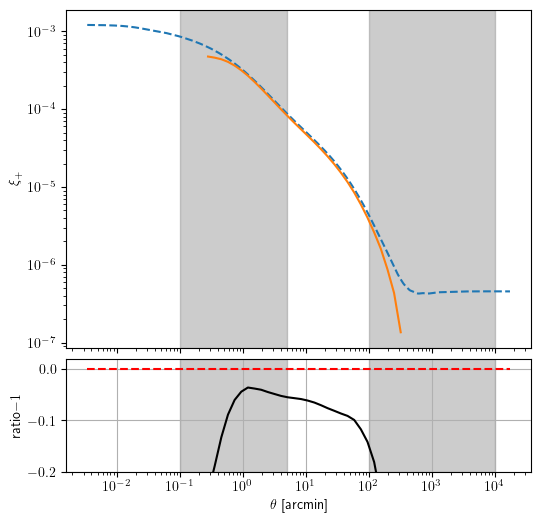

In [11]:
fig=plt.figure(figsize=(6,6))
axes=fig.subplots(2,1,gridspec_kw={'height_ratios':[3, 1],'hspace':0.05},sharex=True)
ax1=axes[0]
ax1.plot(xi_s[0],xi_s[1],'--',label='Model')
ax1.plot(meanr,xi_mock[0],'-',label='Mock')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'$\xi_+$')

ax1.axvspan(1e2, 1e4, alpha=0.4,color='gray')
ax1.axvspan(1e-1, 5, alpha=0.4,color='gray')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2=axes[1]
ax2.set_ylabel(r'ratio$-1$')
ax2.set_xlabel(r'$\theta$ [arcmin]')
ax2.set_xscale('log')
ax2.set_ylim(-0.2,0.02)
ax2.plot(meanr,xi_mock[0]/xi_sp-1,color='black')
ax2.plot(xi_s[0],np.zeros_like(xi_s[0]),'--',c='red')
ax2.axvspan(1e2, 1e4, alpha=0.4,color='gray')
ax2.axvspan(1e-1, 5, alpha=0.4,color='gray')
#ax2.set_yticks([-0.02,-0.01,0.,0.01,0.02])
ax2.grid()
# in COSMOSIS the default limit is from 0.1 to 5e5
gc.collect()
# bias is ~5% on average at scales 5 arcmin to 80 arcmin

In [47]:
cl_corr = angular_power_spectrum_finite_shell(l, cosmo, linear_power, 
                         q_over_chi_func,q_over_chi_func, 
                         halofit)
# resolution effect
N_SIDE = 8192
l_sim = 1.6*N_SIDE
cl_corr = cl_corr/(1+(l/l_sim)**2)
sel = 3*N_SIDE < l
cl_corr[sel] = 0.0

[0.02515047 0.07629116 0.1286462  0.1823366  0.23749242 0.29425357
 0.35277068 0.41320614 0.47573519 0.54054721 0.60784715 0.67785716
 0.75081841 0.82699319 0.90666727 0.99015256 1.07779021 1.16995404
 1.26705461 1.36954373 1.47791978 1.59273376 1.71459628 1.84418575
 1.98225781 2.12965636 2.28732654 2.45632985 2.63786211 2.83327468
 3.04409963 3.27207994 3.51920556 3.78775707 4.0803584  4.40004123
 4.75032383 5.13530826]
Note: redshifts have been re-sorted (earliest first)


30583

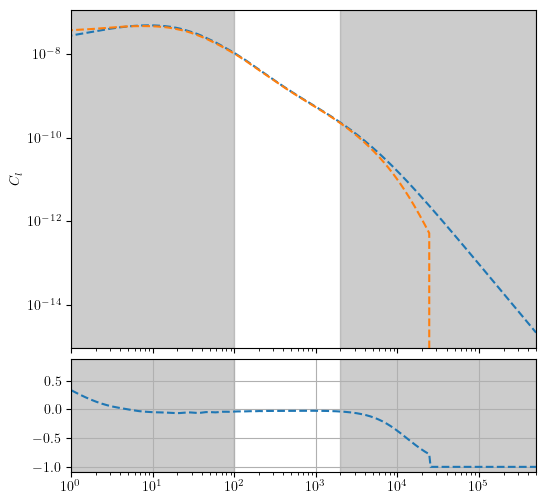

In [48]:
fig=plt.figure(figsize=(6,6))
axes=fig.subplots(2,1,gridspec_kw={'height_ratios':[3, 1],'hspace':0.05},sharex=True)
ax1=axes[0]
ax1.plot(l,cl,'--',label='Model')
ax1.plot(l,cl_corr,'--',label='Model corrected')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1,5e5)
ax1.set_ylabel(r'$C_l$')
ax1.axvspan(2e3, 5e5, alpha=0.4,color='gray')
ax1.axvspan(1, 100, alpha=0.4,color='gray')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2=axes[1]
ax2.axvspan(2e3, 5e5, alpha=0.4,color='gray')
ax2.axvspan(1, 100, alpha=0.4,color='gray')
ax2.plot(l,cl_corr/cl-1,'--',label='ratio')
ax2.grid()
# in COSMOSIS the default limit is from 0.1 to 5e5
gc.collect()
# average bias should be less than 0.005 at the scales of interest

nu is required to be between (0.5-n) and 2.
0 400 0
0 400 0


20274

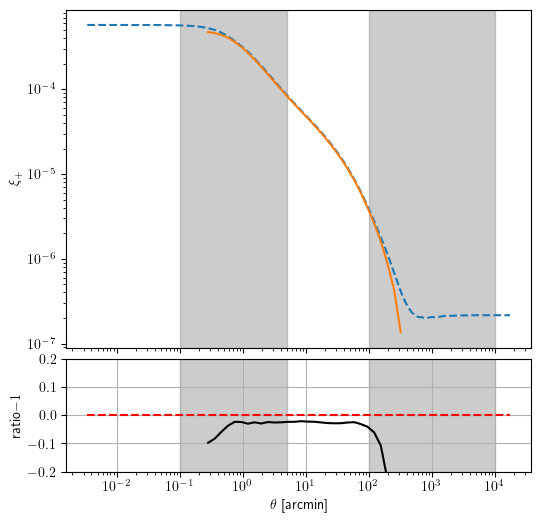

In [49]:
xi_sc = cl2xipm(l, cl_corr,N_extrap_low=0)
xi_spc=Interp1d(xi_sc[0],xi_sc[1])(meanr)
fig=plt.figure(figsize=(6,6))
axes=fig.subplots(2,1,gridspec_kw={'height_ratios':[3, 1],'hspace':0.05},sharex=True)
ax1=axes[0]
ax1.plot(xi_sc[0],xi_sc[1],'--',label='Model correct')
ax1.plot(meanr,xi_mock[0],'-',label='Mock')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'$\xi_+$')

ax1.axvspan(1e2, 1e4, alpha=0.4,color='gray')
ax1.axvspan(1e-1, 5, alpha=0.4,color='gray')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2=axes[1]
ax2.set_ylabel(r'ratio$-1$')
ax2.set_xlabel(r'$\theta$ [arcmin]')
ax2.set_xscale('log')
ax2.set_ylim(-0.2,0.2)
ax2.plot(meanr,xi_mock[0]/xi_spc-1,color='black')
ax2.plot(xi_s[0],np.zeros_like(xi_s[0]),'--',c='red')
ax2.axvspan(1e2, 1e4, alpha=0.4,color='gray')
ax2.axvspan(1e-1, 5, alpha=0.4,color='gray')
#ax2.set_yticks([-0.02,-0.01,0.,0.01,0.02])
ax2.grid()
# in COSMOSIS the default limit is from 0.1 to 5e5
gc.collect()
# bias is ~5% on average at scales 5 arcmin to 80 arcmin